# 08. PyTorch Paper Replicating
-  we're going to be replicating a machine learning research paper and creating a Vision Transformer (ViT) from scratch using PyTorch.

### 0. Getting setup

In [1]:
# !pip install -q tqdm

In [2]:
# Continue with regular imports
import matplotlib.pyplot as plt 
import torch
import torchvision

from torch import nn 
from torchvision import transforms

try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo 
    from torchinfo import summary

try:
    from going_modular import data_setup, engine
    from helper_functions import plot_loss_curves, set_seeds, download_data
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
    

C:\Users\Gaming\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### 1. Get Data

In [4]:
# Download the data from github
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                          destination="pizza_steak_sushi")



[INFO] data\pizza_steak_sushi directory exists, skipping download.


In [5]:
# Setup directory paths to train and test images
train_dir = image_path / "train"
test_dir = image_path / "test"

### 2. Create Datasets and DataLoaders

#### 2.1 Prepare transforms for images

In [6]:
# Create image size (from Table 3 in the ViT paper)
IMG_SIZE = 224

# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])
print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


####  2.2 Turn images into DataLoader's
- The ViT paper states the use of a batch size of 4096 which is 128x the size of the batch size we've been using (32).

- However, we're going to stick with a batch size of 32.

- Why?

    - Because some hardware (including the free tier of Google Colab) may not be able to handle a batch size of 4096.

    - Having a batch size of 4096 means that 4096 images need to fit into the GPU memory at a time.

    - This works when you've got the hardware to handle it like a research team from Google often does but when you're running on a single GPU (such as using Google Colab), making sure things work with smaller batch size first is a good idea.


In [7]:
# Set the batch size
BATCH_SIZE = 32 # this is lower than the ViT paper but it's because we're starting small

# Create data loader 
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir, 
                                                                              test_dir=test_dir,
                                                                              transform=manual_transforms,
                                                                              batch_size=BATCH_SIZE)
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x2269c5b5d30>,
 ['pizza', 'steak', 'sushi'])

#### 2.3 Visualize a single image

In [8]:
img_batch, label_batch = next(iter(train_dataloader))

img, label = img_batch[0], label_batch[0]

img.shape, label

(torch.Size([3, 224, 224]), tensor(0))

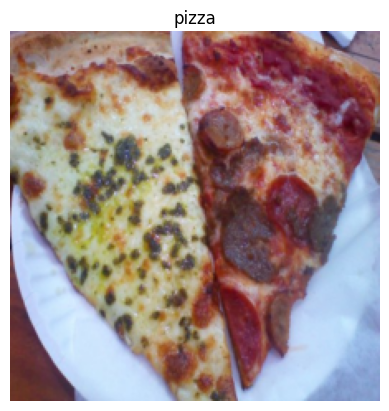

In [9]:
plt.imshow(img.permute(1,2, 0))
plt.title(class_names[label])
plt.axis(False);

### 3. Replicating the ViT paper: an overview
- And any neural network architecture is generally comprised of layers.

- And a collection of layers is often referred to as a block.

- And stacking many blocks together is what gives us the whole architecture.

- Layer - takes an input, performs a function on it, returns an output.
- Block - a collection of layers, takes an input, performs a series of functions on it, returns an output.
- Architecture (or model) - a collection of blocks, takes an input, performs a series of functions on it, returns an output.

<img src="ViT_Archi.png"/>
<img src="4Equations.png"/>

- Patch + Position Embedding (inputs) - Turns the input image into a sequence of image patches and adds a position number to specify in what order the patch comes in.
- Linear projection of flattened patches (Embedded Patches) - The image patches get turned into an embedding, the benefit of using an embedding rather than just the image values is that an embedding is a learnable representation (typically in the form of a vector) of the image that can improve with training.
- Norm - This is short for "Layer Normalization" or "LayerNorm", a technique for regularizing (reducing overfitting) a neural network, you can use LayerNorm via the PyTorch layer torch.nn.LayerNorm().
- Multi-Head Attention - This is a Multi-Headed Self-Attention layer or "MSA" for short. You can create an MSA layer via the PyTorch layer torch.nn.MultiheadAttention().
- MLP (or Multilayer perceptron) - A MLP can often refer to any collection of feedforward layers (or in PyTorch's case, a collection of layers with a forward() method). In the ViT Paper, the authors refer to the MLP as "MLP block" and it contains two torch.nn.Linear() layers with a torch.nn.GELU() non-linearity activation in between them (section 3.1) and a torch.nn.Dropout() layer after each (Appendix B.1).
- Transformer Encoder - The Transformer Encoder, is a collection of the layers listed above. There are two skip connections inside the Transformer encoder (the "+" symbols) meaning the layer's inputs are fed directly to immediate layers as well as subsequent layers. The overall ViT architecture is comprised of a number of Transformer encoders stacked on top of eachother.
- MLP Head - This is the output layer of the architecture, it converts the learned features of an input to a class output. Since we're working on image classification, you could also call this the "classifier head". The structure of the MLP Head is similar to the MLP block.